## 10 - 텍스트 분석 실습 - 캐글
- pric가 예측해야 할 타깃으로 회귀로 피처를 학습한 뒤 prive를 예측하는 문제
- item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행




## 데이터 전처리

In [1]:
import nltk
nltk.download('punkt')         # 문장 토큰화에 필요
nltk.download('stopwords')     # 불용어 처리에 필요
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name 칼럼의 경우 매우 많은 Null값을 가지고 있음,


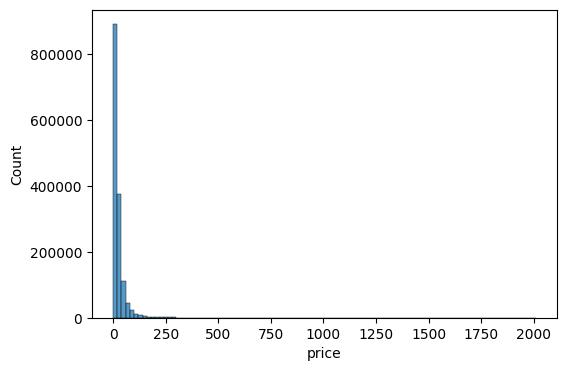

In [4]:
# Target 값인 칼럼의 데이터 분포도 값 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()


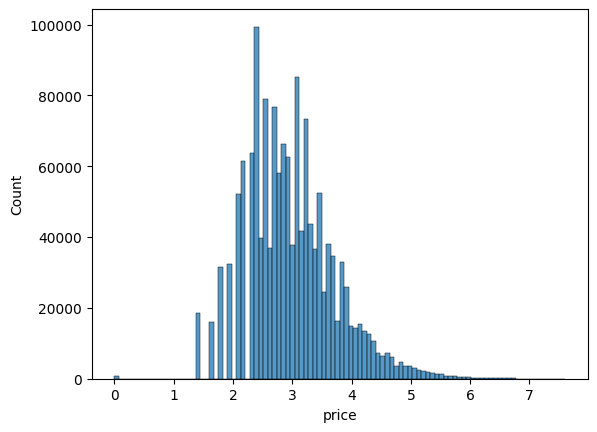

In [5]:
# price 칼럼을 로그 값으로 변환 후 분포도 다시 살펴보기
import numpy as np
y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=100)
plt.show()

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [7]:
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts())
print('Item Condition 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형: 
 shipping
0    819435
1    663100
Name: count, dtype: int64
Item Condition 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [8]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df.loc[boolean_cond, 'item_description'].count()

np.int64(82489)

In [9]:
# zip과 *를 apply lambda 식에 적용해 간단하게 분리
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대,중,소 칼럼을 mercari_df에 생성.
# '*'은 리스트나 튜플 안에 있는 요소를 하나씩 꺼내는 것
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 유형 :\n', mercari_df['cat_jung'].value_counts())
print('소분류 유형 :\n', mercari_df['cat_so'].value_counts())

대분류 유형 :
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형 :
 cat_jung
Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: count, Length: 114, dtype: int64
소분류 유형 :
 cat_so
Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         321

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


## 피처 인코딩과 피처 벡터화
- 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변화할 칼럼을 선별
- 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용
- 피처벡터화의 경우 짧은 텍스트의 경우 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화 적용.

In [11]:
# brand_name 칼럼 검토
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건ㅣ \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건ㅣ 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [12]:
# 상품명을 의미하는 name 속성이 어떤 유형으로 되어 있는지 유형 건수와 상품명 7개 출력
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'][:7])

name의 종류 개수: 1225273
name sample 7건:
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [13]:
# shipping, item_condition_id 칼럼을 모두 원-핫 인코딩 적용
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


In [14]:
# 주요 칼럼을 인코딩 및 피처 벡터화 변환(name, item_description)
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 속성에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_desc = tfidf_descp.fit_transform(mercari_df['item_description'])

In [15]:
print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_desc.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [16]:
from tkinter.constants import X
# 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [17]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [18]:
# del '객체 변수명'와 gc.collect()로 결합 데이터를 메모리에서 삭
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_desc, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_feauture_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_feauture_sparse), X_feauture_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_feauture_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

## 릿지 회귀 모델 구축 및 평가
- 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것이므로 수행에 필요한 로직을 함수화
- 먼저, 모델을 평가하는 평가 로직을 함수화
- RMSLE 방식으로 적용, 오류 값에 로그를 취해 RMSE를 구하는 방식

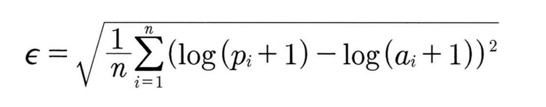

In [19]:
# 별도의 RMSLE를 구하는 함수 rmsle(y, y_pred)로 생성
# 원본 데이터의 price 칼럼의 값은 왜곡된 데이터 분포를 가지므로 이를 정규분포 형태로 유도하는 것 필요.
# 학습에 예측된 price 값은 다시 로그의 역변환인 지수 변환을 수행해 원복 (evaluate_org_price(y_test, preds)함수 생성)

def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmlse로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result


In [20]:
# 학습 데이터를 생성하고 모델을 학습/예측하는 로직을 별도의 함수로 만들기
# model_train_prdict() 함수 이용
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

In [21]:
# 먼저 Ridge를 이용해 Mercari Price의 회귀 에측을 수행
# Item_description 속성의 피처 벡터화 데이터가 포함되었을 때와 포함되지 않을 떄 예측 성능 비교
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_desc, X_name, X_brand, X_item_cond_id, \
                   X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_desc, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4680432471796771
Item Description을 포함했을 때 rmsle 값: 0.4680432471796771


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 에측 평가

- LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 에측값과 LightGBM 모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [22]:
# n_estimators를 200으로 작게 설정하고 예측 성능 측정
# 너무 오래 걸리므로 n_estimator를 20으로 설정하고 force_row_wise=True 등 추가,  num_leaves=31, learning_rate=0.1  등 설정
from lightgbm import LGBMRegressor
sparse_matrix_list = (X_desc, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=20, num_leaves=31,max_bin=63,subsample=0.7, colsample_bytree=0.7, min_data_in_leaf=100,learning_rate=0.1, random_state=156, force_row_wise=True, n_jobs=-1,verbosity=-1)  # 추가
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM을 이용한 rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM을 이용한 rmsle 값: 0.6176014620917475


In [23]:
# Ridge 예측 데이터 세트인 linear_preds에 일괄적으로 0.55를 곱하고, LightGBM 예측 데이터 세트인 lgbm_preds에 일괄적으로 0.45를 곱한 뒤 결과 데이터 세트로 예측 성능 결과 다시 측정
preds = lgbm_preds * 0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.49477023616835275


## 11. 정리
- 텍스트 분석을 위한 기반 프로세스를 상세히 알아보고, 특스트 분류, 감성 분석, 토픽 모델링, 텍스트 군집화 및 유사도 측정 등을 직접 파이썬 코드로 구현
- 머신러닝 기반의 텍스트 분석 프로세스
1. 텍스트 사전 정제 작업 등의 텍스트 정규화 작업 수행
2. 단어들을 피처 벡터화로 변환
3. 피처 벡터 데이터 세트에 머신러닝 모델을 학습하고 예측, 평가

- 텍스트 정규화 작업: 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미없는 단어 필터링, 어근 추출 등 피처 벡터화를 진행하기 이전에 수행하는 다양한 사전 작업
- 피처 벡터화 방법: BOW의 Count 기반과 TF-IDF 기반 피처 벡터화
- 텍스트 분류절: 문서들을 피처 벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 분류
  - 긍정/부정 이진 분류
  - SentiWordNet, VADER와 같은 감정 사전 Lexicon을 이용한 방식
  